# Nashville Area Weather Data

## Library Imports

In [150]:
# data collection and formatting
import os
import re
import json
import gzip
import requests
from io import BytesIO

#tables and visualizations
import pyarrow
from pyarrow import feather
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 20

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve

## Loading the Data

In [2]:
# common vars/paths
branch = 'cleaner-data'
curr_dir = os.getcwd()
data_dir = os.path.join(curr_dir, 'data')
gh_data_root = "https://github.com/brtonnies/nashville-area-weather-dataset/blob/{}/data".format(branch)

# flag so that we only load the remote data once (when set True), then manipulate it here
remote = True

# if you're saving the data :
def save_feathers(df, name='isd'):
    feather_dir = os.path.join(data_dir, name)
    os.makedirs(feather_dir, exist_ok=True)
    for month in range(1,13,1):
        feather.write_feather(
            df[df['month'] == month], 
            os.path.join(feather_dir, "feather_{}".format(month))
        )
        
def test_save(df, name='test/station-month'):
    feather_dir = os.path.join(data_dir, name)
    stations = set(list(df['station']))
    for station in stations:
        feather_dir = os.path.join(feather_dir, station)
        os.makedirs(os.path.join(feather_dir, station), exist_ok=True)
        for month in range(1,13,1):
            feather.write_feather(
                df[(df['station'] == station) & (df['month'] == month)],
                os.path.joinn(feather_dir, "feather_{}".format(month))
            )
        

# **NOTE**: remember to download the feathers 
# from colab if you're changing data and want it committed

# if you're retrieving the data.
def load_feathers(name='isd', remote=remote):
    frames = []
    feather_dir = os.path.join(data_dir, name)
    for month in range(1,13,1):
        if remote:
            res = requests.get(
                "{}/{}/feather_{}?raw=true".format(gh_data_root, name, month), 
                stream=True)
            res.raw.decode_content = True
            fobj = BytesIO(res.raw.read())
            frames.append(
                feather.read_feather(fobj)
            )
        else:
            frames.append(
                feather.read_feather(
                    os.path.join(feather_dir, "feather_{}".format(month))
                )
            )
    remote = False
    return pd.concat(frames, ignore_index=True)


isd = load_feathers()
isdlite = load_feathers(name='isdlite')

In [72]:
isd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577003 entries, 0 to 3577002
Data columns (total 63 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   station                              int64         
 1   latitude                             float64       
 2   longitude                            float64       
 3   elevation                            float64       
 4   quality_control                      object        
 5   year                                 int64         
 6   month                                int64         
 7   day                                  int64         
 8   hour                                 int64         
 9   minute                               int64         
 10  sky_ceiling                          int64         
 11  sky_ceiling_qual                     float64       
 12  sky_ceiling_determination_code       object        
 13  visibility_variable        

In [4]:
p = isd.apply(lambda x: x['repl_precipitation_depth'] if np.isnan(x['precipitation_depth']) else x['precipitation_depth'], axis=1)
isd['combined_precipitation_depth'] = p
isd['weather_atmospheric_condition'] = pd.to_numeric(isd['weather_atmospheric_condition'])

In [70]:
# save_feathers(isd, 'isd_no_qual')

In [75]:
['humidity_period_quantity', 'humidity_code', 'humidity_percentage', 'humidity_derived_code']
isd.drop(columns=[c for c in isd.columns if 'qual' in c], inplace=True)
isd.isna().sum()

station                                 0
latitude                                0
longitude                               0
elevation                               0
year                                    0
month                                   0
day                                     0
hour                                    0
minute                                  0
sky_ceiling                             0
sky_ceiling_determination_code          0
visibility_variable                     0
dew_point_temperature              475550
air_temperature                    473290
wind_direction                    1122402
wind_type                               0
wind_speed                         401206
precipitation_period              1231568
precipitation_depth               1229509
precipitation_condition           3405801
proximity_intensity               3287687
descriptor_code                   3287687
precipitation_code                3287687
obscuration_code                  

In [55]:
cols = [
    'short_station_id',
    'combined_precipitation_depth', 
    'observed_atmospheric_condition', 
    'weather_atmospheric_condition',
    'precipitation_condition',
    'descriptor_code',
    'precipitation_code',
    'obscuration_code',
    'other_phenomena_code',
]

df = isd[cols]
df[cols].sample(15)

,short_station_id,combined_precipitation_depth,observed_atmospheric_condition,weather_atmospheric_condition,precipitation_condition,descriptor_code,precipitation_code,obscuration_code,other_phenomena_code
3268980,13897,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2994279,13897,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1018306,13882,46.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN
1306949,13882,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3072829,13891,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2620763,93808,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1872740,13891,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693479,13891,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
791510,03811,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3014130,13897,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
pcarr_desc = [
	'No precipitation',
	'Drizzle',
	'Rain',
	'Snow',
	'Snow Grains',
	'Ice Crystals',
	'Ice Pellets',
	'Hail',
	'Small Hail and/or Snow Pellets',
	'Unknown Precipitation',
	'Missing'
]

pcarr = [i for i in range(0,10,1) ]
pcarr.append(99)
precipitation_code_map = dict(zip(pcarr, pcarr_desc))
pcm = precipitation_code_map

precipitation_code_remap = {
    'no precipitation': [k for k,v in precipitation_code_map.items() if k == 0],
    'drizzle': [k for k,v in pcm.items() if k == 1],
    'rain': [k for k,v in precipitation_code_map.items() if k == 2],
    'snow': [k for k,v in precipitation_code_map.items() if k in [3, 4, 5]],
    'hail': [k for k,v in precipitation_code_map.items() if k in [6, 7, 8]],
    'unkown/missing': [k for k in precipitation_code_map.keys() if k in [9, 99]]
}
# invert the keys and values because I'm silly
pcr = {}
for d in precipitation_code_remap.keys():
    for c in precipitation_code_remap[d]:
        pcr[c] = d
# pcr = precipitation_code_map

In [9]:
pcs = df['precipitation_code'].apply(lambda x: pcr[x] if x in pcr.keys() else x)
pcs[pcs.notna()].value_counts()

no precipitation    159822
rain                111202
snow                 13260
drizzle               3655
unkown/missing        1130
hail                   247
Name: precipitation_code, dtype: int64

In [10]:
descriptors = [
	'No descriptor',
	'Shallow',
	'Partial',
	'Patches',
	'Low Drifting',
	'Blowing',
	'Showers',
	'Thunderstorm',
	'Freezing',
	np.nan
]

dcarr = [i for i in range(0,10,1)]
descriptor_code_map = dict(zip(dcarr, descriptors))
dcm = descriptor_code_map


dcs = df['descriptor_code'].apply(lambda x: dcm[x].lower() if x in dcm.keys() else x)
dcs[dcs.notna()].value_counts()

no descriptor    249428
thunderstorm      33667
patches            2938
freezing           2563
shallow             714
blowing               6
Name: descriptor_code, dtype: int64

In [11]:
phenom_desc = [
	'None Reported',
	'Well-developed Dust/Sand Whirls',
	'Squalls',
	'Funnel Cloud, Tornado, Waterspout',
	'Sandstorm',
	'Duststorm',
	'Missing'
]

phenom_arr = [i for i in range(0,6,1)]
phenom_arr.append(9)
opcm = dict(zip(phenom_arr, phenom_desc))

ops = df['other_phenomena_code'].apply(lambda x: opcm[x] if x in opcm.keys() else x)
ops[ops.notna()].value_counts()

None Reported                        289287
Squalls                                  24
Funnel Cloud, Tornado, Waterspout         4
Duststorm                                 1
Name: other_phenomena_code, dtype: int64

In [12]:
obscure_desc = [
	'No Obscuration',
	'Mist',
	'Fog',
	'Smoke',
	'Volcanic Ash',
	'Widespread Dust',
	'Sand',
	'Haze',
	'Spray',
	'Missing'
]
obscure_arr = [i for i in range(0,10,1)]
ocm = dict(zip(obscure_arr, obscure_desc))

ocs = df['other_phenomena_code'].apply(lambda x: ocm[x] if x in ocm.keys() else x)
ocs[ocs.notna()].value_counts()

No Obscuration     289287
Fog                    24
Smoke                   4
Widespread Dust         1
Name: other_phenomena_code, dtype: int64

### Atmospheric Condition Codes
They get their own header because they're 100 lines apiece.

In [67]:
weather_atmospheric_condition_map = {
	0: 'No significant weather observed', #
	1: 'Clouds generally dissolving or becoming less developed', #
	2: 'State of sky on the whole unchanged during the past hour', #
	3: 'Clouds generally forming or developing during the past hour', #
	4: 'Haze, smoke, or dust in suspension in the air, visibility equal to or greater than 1km', #
	5: 'Smoke', #
	7: 'Dust or sand raised by wind at or near the station at the time of observation, but no well-developed dust irl(s) whirls(s) or sand whirl(s), and no duststorm or sandstorm seen or, in the case of ships, blowing spray at the station', #
	10: 'Mist',
	11: 'Diamond dust',
	12: 'Distant lightning',
	18: 'Squalls',
	20: 'Fog',
	21: 'Precipitation',
	22: 'Drizzle (not freezing) or snow grains',
	23: 'Rain (not freezing)',
	24: 'Snow',
	25: 'Freezing drizzle or freezing rain',
	26: 'Thunderstorm (with or without precipitation)',
	27: 'Blowing or drifting snow or sand',
	28: 'Blowing or drifting snow or sand, visibility equal to or greater than 1 km',
	29: 'Blowing or drifting snow or sand, visibility less than 1 km',
	30: 'Fog',
	31: 'Fog or ice fog in patches',
	32: 'Fog or ice fog, has become thinner during the past hour',
	33: 'Fog or ice fog, no appreciable change during the past hour',
	34: 'Fog or ice fog, has begun or become thicker during the past hour',
	35: 'Fog, depositing rime',
	40: 'Precipitation',
	41: 'Precipitation, slight or moderate',
	42: 'Precipitation, heavy',
	43: 'Liquid precipitation, slight or moderate',
	44: 'Liquid precipitation, heavy',
	45: 'Solid precipitation, slight or moderate',
	46: 'Solid precipitation, heavy',
	47: 'Freezing precipitation, slight or moderate',
	48: 'Freezing precipitation, heavy',
	50: 'Drizzle',
	51: 'Drizzle, not freezing, slight',
	52: 'Drizzle, not freezing, moderate',
	53: 'Drizzle, not freezing, heavy',
	54: 'Drizzle, freezing, slight',
	55: 'Drizzle, freezing, moderate',
	56: 'Drizzle, freezing, heavy',
	57: 'Drizzle and rain, slight',
	58: 'Drizzle and rain, moderate or heavy',
	60: 'Rain',
	61: 'Rain, not freezing, slight',
	62: 'Rain, not freezing, moderate',
	63: 'Rain, not freezing, heavy',
	64: 'Rain, freezing, slight',
	65: 'Rain, freezing, moderate',
	66: 'Rain, freezing, heavy',
	67: 'Rain or drizzle and snow, slight',
	68: 'Rain or drizzle and snow, moderate or heavy',
	70: 'Snow',
	71: 'Snow, slight',
	72: 'Snow, moderate',
	73: 'Snow, heavy',
	74: 'Ice pellets, slight',
	75: 'Ice pellets, moderate',
	76: 'Ice pellets, heavy',
	77: 'Snow grains',
	78: 'Ice crystals',
	80: 'Showers or intermittent precipitation',
	81: 'Rain showers or intermittent rain, slight',
	82: 'Rain showers or intermittent rain, moderate',
	83: 'Rain showers or intermittent rain, heavy',
	84: 'Rain showers or intermittent rain, violent',
	85: 'Snow showers or intermittent snow, slight',
	86: 'Snow showers or intermittent snow, moderate',
	87: 'Snow showers or intermittent snow, heavy',
	89: 'Hail',
	90: 'Thunderstorm',
	91: 'Thunderstorm, slight or moderate, with no precipitation',
	92: 'Thunderstorm, slight or moderate, with rain showers and/or snow showers',
	93: 'Thunderstorm, slight or moderate, with hail',
	94: 'Thunderstorm, heavy, with no precipitation',
	95: 'Thunderstorm, heavy, with rain showers and/or snow',
	96: 'Thunderstorm, heavy, with hail',
	99: 'Tornado'
}

weather_atmospheric_condition_remap = {
    'no significant weather': [0],
    'clouds clearing': [1],
    'sky unchanged': [2],
    'getting cloudy': [3],
    'thunderstorm': [26, 90, 91, 92, 93, 94, 95, 96],
    'haze, smoke, or dust': [4, 5, 7, 11],
    'fog': [i for sublist in [[20], [j for j in range(30,36)]] for i in sublist],
    'mist': [10],
    'distant lightning': [12],
    'squalls': [18],
    'precipitation': [21, 40, 41, 42, 43, 44, 45, 46, 47, 48, 80],
    'drizzle': [50, 51, 52, 53, 54, 55, 56],
    'rain': [i for sublist in [[j for j in range(57, 67)], [k for k in range(81,85)]] for i in sublist if i != 59],
    'wintry mix, snow, or ice pellets': [i for sublist in [[27], [j for j in range(67, 79)], [k for k in range(85, 89)]] for i in sublist if i != 69],
    'hail': [89],
    'tornado': [99]
}

# invert the keys and values because I'm silly
wacmr = {}
for d in weather_atmospheric_condition_remap.keys():
    for c in weather_atmospheric_condition_remap[d]:
        wacmr[c] = d
        
# display(weather_atmospheric_condition_remap)
wacm = weather_atmospheric_condition_map
# wacs = df['weather_atmospheric_condition'].apply(lambda x: wacm[x] if x in wacm.keys() else x)
wacs = df['weather_atmospheric_condition'].apply(lambda x: wacmr[x] if x in wacmr.keys() else x)
wacs[wacs.notna()].value_counts()

mist                                195191
rain                                 50070
fog                                  18297
wintry mix, snow, or ice pellets      6420
haze, smoke, or dust                  6290
thunderstorm                          5637
distant lightning                     5401
drizzle                                978
precipitation                          513
squalls                                180
17.0                                     6
hail                                     3
tornado                                  1
no significant weather                   1
Name: weather_atmospheric_condition, dtype: int64

In [94]:
observed_atmospheric_condition_map = {
	0: 'Cloud development not observed or not observable',
	1: 'Clouds generally dissolving or becoming less developed',
	2: 'State of sky on the whole unchanged',
	3: 'Clouds generally forming or developing',
	4: 'Visibility reduced by smoke, e.g. veldt or forest fires, industrial smoke or volcanic ashes',
	5: 'Haze',
	6: 'Widespread dust in suspension in the air, not raised by wind at or near the station at the time of observation',
	7: 'Dust or sand raised by wind at or near the station at the time of observation, but no well-developed dust whirl(s) sand whirl(s), and no duststorm or sandstorm seen or, in the case of ships, blowing spray at the station',
	8: 'Well developed dust whirl(s) or sand whirl(s) seen at or near the station during the preceding hour or at the time of observation, but no duststorm or sandstorm',
	9: 'Duststorm or sandstorm within sight at the time of observation, or at the station during the preceding hour',
	10: 'Mist',
	11: 'Patches of shallow fog or ice fog at the station, whether on land or sea, not deeper than about 2 meters on land or 10 meters at sea',
	12: 'More or less continuous shallow fog or ice fog at the station, whether on land or sea, not deeper than about 2 meters on land or 10 meters at sea',
	13: 'Lightning visible, no thunder heard',
	14: 'Precipitation within sight, not reaching the ground or the surface of the sea',
	15: 'Precipitation within sight, reaching the ground or the surface of the sea, but distant, i.e., estimated to be more than 5 km from the station',
	16: 'Precipitation within sight, reaching the ground or the surface of the sea, near to, but not at the station',
	17: 'Thunderstorm, but no precipitation at the time of observation',
	18: 'Squalls at or within sight of the station during the preceding hour or at the time of observation',
	19: 'Funnel cloud(s) (Tornado cloud or waterspout) at or within sight of the station during the preceding hour or at the time of observation',
	20: 'Drizzle (not freezing) or snow grains not falling as shower(s)',
	21: 'Rain (not freezing) not falling as shower(s)',
	22: 'Snow not falling as shower(s)',
	23: 'Rain and snow or ice pellets not falling as shower(s)',
	24: 'Freezing drizzle or freezing rain not falling as shower(s)',
	25: 'Shower(s) of rain',
	26: 'Shower(s) of snow or of rain and snow',
	27: 'Shower(s) of hail (Hail, small hail, snow pellets), or rain and hail',
	28: 'Fog or ice fog',
	29: 'Thunderstorm (with or without precipitation)',
	30: 'Slight or moderate duststorm or sandstorm has decreased during the preceding hour',
	31: 'Slight or moderate duststorm or sandstorm no appreciable change during the preceding hour',
	32: 'Slight or moderate duststorm or sandstorm has begun or has increased during the preceding hour',
	33: 'Severe duststorm or sandstorm has decreased during the preceding hour',
	34: 'Severe duststorm or sandstorm no appreciable change during the preceding hour',
	35: 'Severe duststorm or sandstorm has begun or has increased during the preceding hour',
	36: 'Slight or moderate drifting snow generally low (below eye level)',
	37: 'Heavy drifting snow generally low (below eye level)',
	38: 'Slight or moderate blowing snow generally high (above eye level)',
	39: 'Heavy blowing snow generally high (above eye level)',
	40: 'Fog or ice fog at a distance at the time of observation, but not at the station during the preceding hour, the fog or ice fog extending to a level above that of the observer',
	41: 'Fog or ice fog in patches',
	42: 'Fog or ice fog, sky visible, has become thinner during the preceding hour',
	43: 'Fog or ice fog, sky invisible, has become thinner during the preceding hour',
	44: 'Fog or ice fog, sky visible, no appreciable change during the preceding hour',
	45: 'Fog or ice fog, sky invisible, no appreciable change during the preceding hour',
	46: 'Fog or ice fog, sky visible, has begun or has become thicker during the preceding hour',
	47: 'Fog or ice fog, sky invisible, has begun or has become thicker during the preceding hour',
	48: 'Fog, depositing rime, sky visible',
	49: 'Fog, depositing rime, sky invisible',
	50: 'Drizzle, not freezing, intermittent, slight at time of observation',
	51: 'Drizzle, not freezing, continuous, slight at time of observation',
	52: 'Drizzle, not freezing, intermittent, moderate at time of observation',
	53: 'Drizzle, not freezing, continuous, moderate at time of observation',
	54: 'Drizzle, not freezing, intermittent, heavy (dense) at time of observation',
	55: 'Drizzle, not freezing, continuous, heavy (dense) at time of observation',
	56: 'Drizzle, freezing, slight',
	57: 'Drizzle, freezing, moderate or heavy (dense)',
	58: 'Drizzle and rain, slight',
	59: 'Drizzle and rain, moderate or heavy',
	60: 'Rain, not freezing, intermittent, slight at time of observation',
	61: 'Rain, not freezing, continuous, slight at time of observation',
	62: 'Rain, not freezing, intermittent, moderate at time of observation',
	63: 'Rain, not freezing, continuous, moderate at time of observation',
	64: 'Rain, not freezing, intermittent, heavy at time of observation',
	65: 'Rain, not freezing, continuous, heavy at time of observation',
	66: 'Rain, freezing, slight',
	67: 'Rain, freezing, moderate or heavy',
	68: 'Rain or drizzle and snow, slight',
	69: 'Rain or drizzle and snow, moderate or heavy',
	70: 'Intermittent fall of snowflakes, slight at time of observation',
	71: 'Continuous fall of snowflakes, slight at time of observation',
	72: 'Intermittent fall of snowflakes, moderate at time of observation',
	73: 'Continuous fall of snowflakes, moderate at time of observation',
	74: 'Intermittent fall of snowflakes, heavy at time of observation',
	75: 'Continuous fall of snowflakes, heavy at time of observation',
	76: 'Diamond dust (with or without fog)',
	77: 'Snow grains (with or without fog)',
	78: 'Isolated star-like snow crystals (with or without fog)',
	79: 'Ice pellets',
	80: 'Rain shower(s), slight',
	81: 'Rain shower(s), moderate or heavy',
	82: 'Rain shower(s), violent',
	83: 'Shower(s) of rain and snow mixed, slight',
	84: 'Shower(s) of rain and snow mixed, moderate or heavy',
	85: 'Snow shower(s), slight',
	86: 'Snow shower(s), moderate or heavy',
	87: 'Shower(s) of snow pellets or small hail, with or without rain or rain and snow mixed, slight',
	88: 'Shower(s) of snow pellets or small hail, with or without rain or rain and snow mixed, moderate or heavy',
	89: 'Shower(s) of hail (hail, small hail, snow pellets), with or without rain or rain and snow mixed, not associated with thunder, slight',
	90: 'Shower(s) of hail (hail, small hail, snow pellets), with or without rain or rain and snow mixed, not associated with thunder, moderate or heavy',
	91: 'Slight rain at time of observation, thunderstorm during the preceding hour but not at time of observation',
	92: 'Moderate or heavy rain at time of observation, thunderstorm during the preceding hour but not at time of observation',
	93: 'Slight snow, or rain and snow mixed or hail (Hail, small hail, snow pellets), at time of observation, thunderstorm during the preceding hour but not at time of observation',
	94: 'Moderate or heavy snow, or rain and snow mixed or hail(Hail, small hail, snow pellets) at time of observation, thunderstorm during the preceding hour but not at time of observation',
	95: 'Thunderstorm, slight or moderate, without hail (Hail, small hail, snow pellets), but with rain and/or snow at time of observation, thunderstorm at time of observation',
	96: 'Thunderstorm, slight or moderate, with hail (hail, small hail, snow pellets) at time of observation, thunderstorm at time of observation',
	97: 'Thunderstorm, heavy, without hail (Hail, small hail, snow pellets), but with rain and/or snow at time of observation, thunderstorm at time of observation',
	98: 'Thunderstorm combined with duststorm or sandstorm at time of observation, thunderstorm at time of observation',
	99: 'Thunderstorm, heavy, with hail (Hail, small hail, snow pellets) at time of observation, thunderstorm at time of observation'
}

observed_atmospheric_condition_remap = {
    'sky unchanged': [0,2],
    'clouds clearing': [1],
    'getting cloudy': [3],
    'thunderstorm': [i for sublist in [
        [17, 29], 
        [j for j in range(95,100)]
    ] for i in sublist],
    'haze, smoke, or dust': [i for sublist in [
        [j for j in range(30,36)], 
        [k for k in range(4,10)]
    ] for i in sublist],
    'fog': [i for sublist in [
        [11, 12, 28], 
        [j for j in range(40,50)]
    ] for i in sublist],
    'mist': [10],
    'distant lightning': [13],
    'squalls': [18],
    'precipitation': [i for sublist in [
        [j for j in range(14,17)],
        []
    ] for i in sublist],
    'drizzle': [i for sublist in [
        [i for i in range(50,60)],
        [24]
    ] for i in sublist],
    'rain': [i for sublist in [
        [21, 25, 91, 80, 81, 82],
        [j for j in range(60,70)]
    ] for i in sublist],
    'wintry mix, snow, or ice pellets': [i for sublist in [
        [20, 22, 23, 26, 38, 39],
        [j for j in range(70,80)],
        [j for j in range(83, 91)],
        [j for j in range(92, 95)]
    ] for i in sublist],
    'hail': [27],
    'tornado': [19]
}

# invert the keys and values because I'm silly
oacmr = {}
for d in observed_atmospheric_condition_remap.keys():
    for c in observed_atmospheric_condition_remap[d]:
        oacmr[c] = d

oacm = observed_atmospheric_condition_map
# oacmr

In [95]:
# def simple_observed_atmo_condition(code):
#     0: 'Cloud development not observed or not observable',
# 	1: 'Clouds generally dissolving or becoming less developed',
# 	2: 'State of sky on the whole unchanged',
# 	3: 'Clouds generally forming or developing',


display(dcm)
display(pcm)
display(ocm)
display(opcm)
display(wacm)
display(oacm)

{0: 'No descriptor',
 1: 'Shallow',
 2: 'Partial',
 3: 'Patches',
 4: 'Low Drifting',
 5: 'Blowing',
 6: 'Showers',
 7: 'Thunderstorm',
 8: 'Freezing',
 9: nan}

{0: 'No precipitation',
 1: 'Drizzle',
 2: 'Rain',
 3: 'Snow',
 4: 'Snow Grains',
 5: 'Ice Crystals',
 6: 'Ice Pellets',
 7: 'Hail',
 8: 'Small Hail and/or Snow Pellets',
 9: 'Unknown Precipitation',
 99: 'Missing'}

{0: 'No Obscuration',
 1: 'Mist',
 2: 'Fog',
 3: 'Smoke',
 4: 'Volcanic Ash',
 5: 'Widespread Dust',
 6: 'Sand',
 7: 'Haze',
 8: 'Spray',
 9: 'Missing'}

{0: 'None Reported',
 1: 'Well-developed Dust/Sand Whirls',
 2: 'Squalls',
 3: 'Funnel Cloud, Tornado, Waterspout',
 4: 'Sandstorm',
 5: 'Duststorm',
 9: 'Missing'}

{0: 'No significant weather observed',
 1: 'Clouds generally dissolving or becoming less developed',
 2: 'State of sky on the whole unchanged during the past hour',
 3: 'Clouds generally forming or developing during the past hour',
 4: 'Haze, smoke, or dust in suspension in the air, visibility equal to or greater than 1km',
 5: 'Smoke',
 7: 'Dust or sand raised by wind at or near the station at the time of observation, but no well-developed dust irl(s) whirls(s) or sand whirl(s), and no duststorm or sandstorm seen or, in the case of ships, blowing spray at the station',
 10: 'Mist',
 11: 'Diamond dust',
 12: 'Distant lightning',
 18: 'Squalls',
 20: 'Fog',
 21: 'Precipitation',
 22: 'Drizzle (not freezing) or snow grains',
 23: 'Rain (not freezing)',
 24: 'Snow',
 25: 'Freezing drizzle or freezing rain',
 26: 'Thunderstorm (with or without precipitation)',
 27: 'Blowing or drifting snow or sand',
 28: 'Blowing or drifting snow or sand, visibility equal to or greater than 1 km',
 29: 'B

{0: 'Cloud development not observed or not observable',
 1: 'Clouds generally dissolving or becoming less developed',
 2: 'State of sky on the whole unchanged',
 3: 'Clouds generally forming or developing',
 4: 'Visibility reduced by smoke, e.g. veldt or forest fires, industrial smoke or volcanic ashes',
 5: 'Haze',
 6: 'Widespread dust in suspension in the air, not raised by wind at or near the station at the time of observation',
 7: 'Dust or sand raised by wind at or near the station at the time of observation, but no well-developed dust whirl(s) sand whirl(s), and no duststorm or sandstorm seen or, in the case of ships, blowing spray at the station',
 8: 'Well developed dust whirl(s) or sand whirl(s) seen at or near the station during the preceding hour or at the time of observation, but no duststorm or sandstorm',
 9: 'Duststorm or sandstorm within sight at the time of observation, or at the station during the preceding hour',
 10: 'Mist',
 11: 'Patches of shallow fog or ice fog a

sky unchanged                       1163790
fog                                  210322
mist                                 169109
haze, smoke, or dust                 146717
rain                                 130059
thunderstorm                          21560
wintry mix, snow, or ice pellets      19396
drizzle                                5488
getting cloudy                         5150
clouds clearing                        4979
precipitation                           129
distant lightning                       127
squalls                                  86
tornado                                   4
hail                                      3
Name: observed_atmospheric_condition, dtype: int64

([<matplotlib.patches.Wedge at 0x7fe0d6c69f00>,
 [Text(-0.4051086143909968, 1.0226861740271092, 'SKY UNCHANGED'),
  Text(-0.49271530712361034, -0.9834793470765345, 'FOG'),
  Text(0.18680721957320817, -1.0840217076771699, 'MIST'),
  Text(0.7080354805081889, -0.8418347571474691, 'HAZE, SMOKE, OR DUST'),
  Text(1.0096006478613124, -0.43669958992197183, 'RAIN'),
  Text(1.086903352847498, -0.16923682096065082, 'THUNDERSTORM'),
  Text(1.0959429328418402, -0.09438796509103348, 'WINTRY MIX, SNOW, OR ICE PELLETS'),
  Text(1.0989226585770728, -0.04867227615284391, 'DRIZZLE'),
  Text(1.0996150647821867, -0.029098269777897805, 'GETTING CLOUDY'),
  Text(1.0999503408437268, -0.010452161392239201, 'CLOUDS CLEARING'),
  Text(1.0999995011956787, -0.0010475539404923406, 'PRECIPITATION'),
  Text(1.0999998490821357, -0.0005762111408706474, 'DISTANT LIGHTNING'),
  Text(1.0999999846043662, -0.000184039110823963, 'SQUALLS'),
  Text(1.0999999998472343, -1.8332614055036904e-05, 'TORNADO'),
  Text(1.09999999998

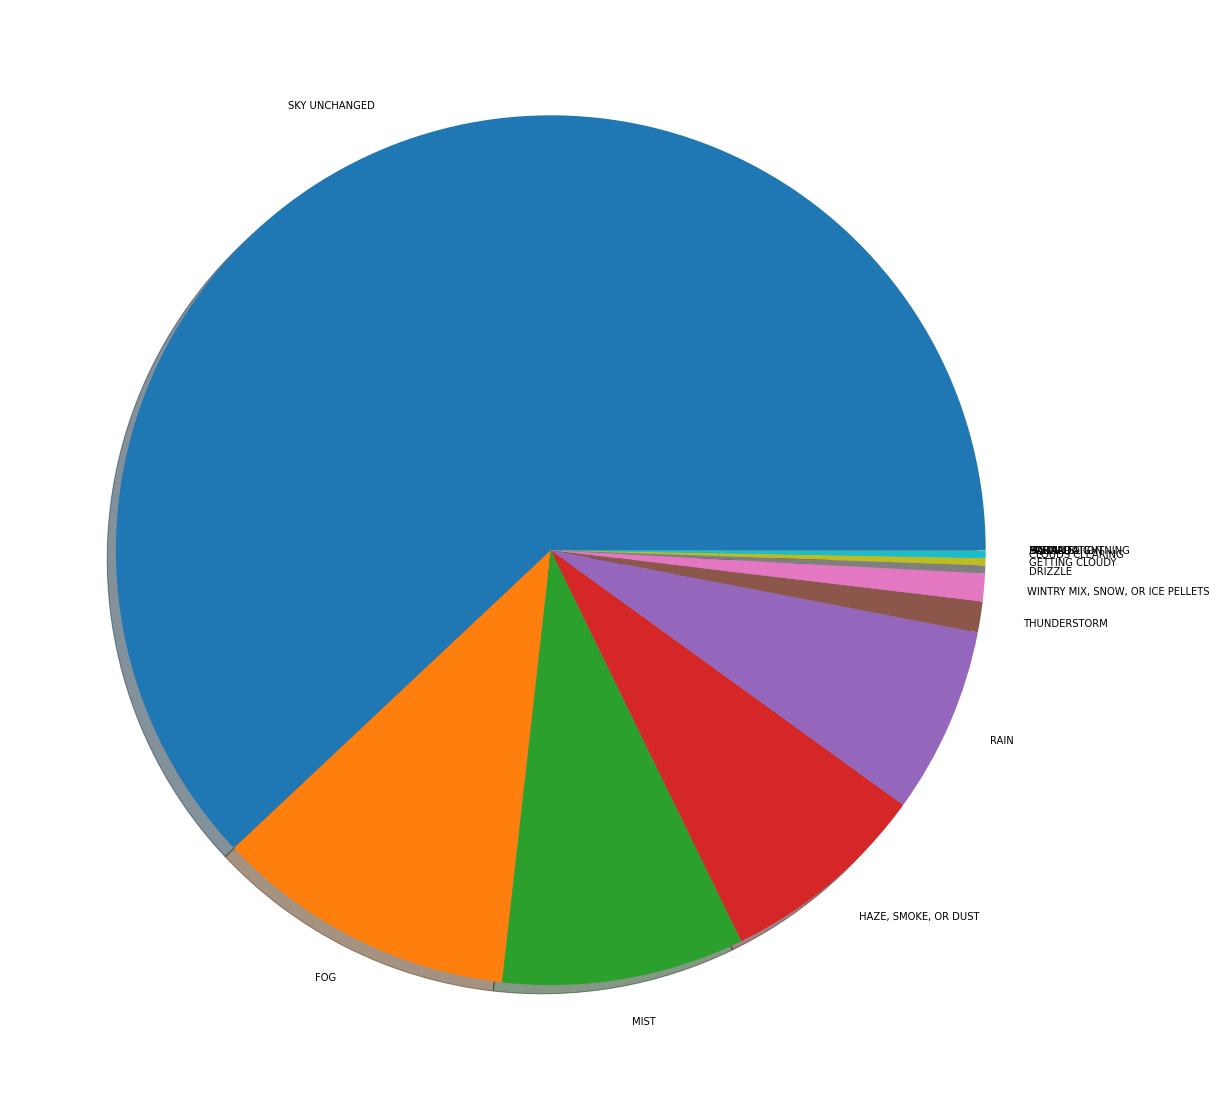

In [96]:
# obsv = df['observed_atmospheric_condition'].apply(lambda x: oacm[x] if x in oacm.keys() else x)
obsv = df['observed_atmospheric_condition'].apply(lambda x: oacmr[x] if x in oacmr.keys() else x)
obsv_counts = obsv[obsv.notna()].value_counts()
display(obsv_counts)
plt.pie(obsv_counts, labels=obsv_counts.index.str.upper(), shadow=True)

mist                                195191
rain                                 50070
fog                                  18297
wintry mix, snow, or ice pellets      6402
haze, smoke, or dust                  6290
thunderstorm                          5637
distant lightning                     5401
drizzle                                978
precipitation                          513
squalls                                180
27.0                                    18
17.0                                     6
hail                                     3
tornado                                  1
no significant weather                   1
Name: weather_atmospheric_condition, dtype: int64

([<matplotlib.patches.Wedge at 0x7fe0463a0c40>,
 [Text(-0.5760131416067084, 0.9371279852274023, 'MIST'),
  Text(0.08326817590864075, -1.0968438406996903, 'RAIN'),
  Text(0.803501662453438, -0.7512556678219218, 'FOG'),
  Text(0.9740109757896245, -0.511177678543717, 'WINTRY MIX, SNOW, OR ICE PELLETS'),
  Text(1.0350606427320863, -0.372356638005878, 'HAZE, SMOKE, OR DUST'),
  Text(1.0745165178316325, -0.23540232137127165, 'THUNDERSTORM'),
  Text(1.094969205773966, -0.10508300722157785, 'DISTANT LIGHTNING'),
  Text(1.0996187325512383, -0.028959333942763787, 'DRIZZLE'),
  Text(1.0999436611295796, -0.011132939452667311, 'PRECIPITATION'),
  Text(1.0999963179108443, -0.0028461522421008444, 'SQUALLS'),
  Text(1.0999998959486537, -0.000478448483358099, 'nan'),
  Text(1.09999998333885, -0.0001914537275639179, 'nan'),
  Text(1.0999999968056433, -8.383069208960587e-05, 'HAIL'),
  Text(1.099999999410967, -3.5998231035766605e-05, 'TORNADO'),
  Text(1.099999999933648, -1.2081999692652293e-05, 'NO SIGN

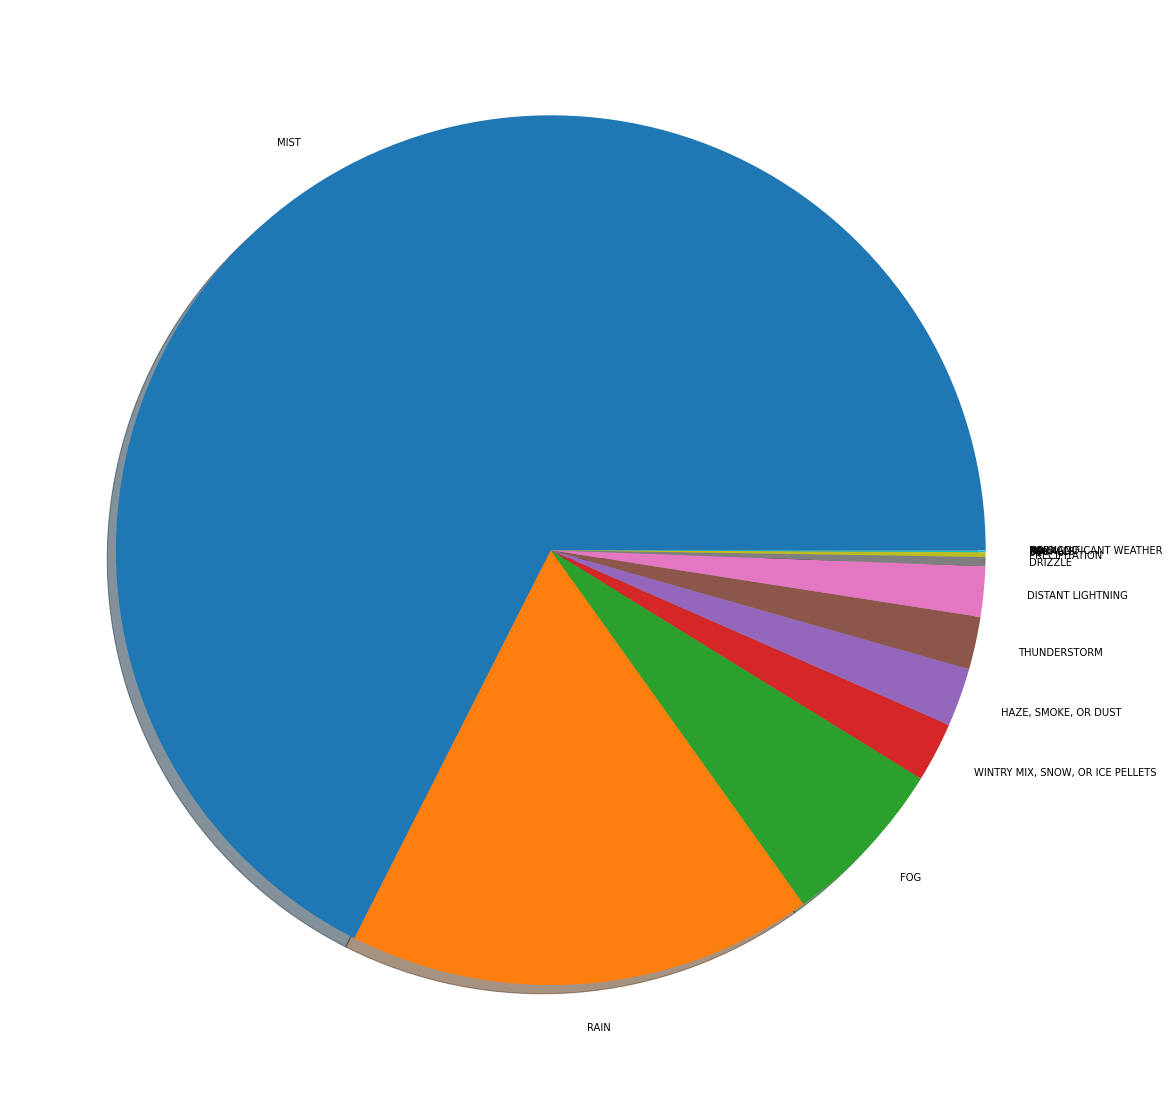

In [65]:
wthac = df['weather_atmospheric_condition'].apply(lambda x: wacmr[x] if x in wacmr.keys() else x) 
wthac_counts = wthac[wthac.notna()].value_counts()
display(wthac_counts)

plt.pie(wthac_counts, labels=wthac_counts.index.str.upper(), shadow=True)

No Obscuration     163209
Mist                96481
Fog                 17230
Haze                12322
Smoke                  70
Widespread Dust         2
Volcanic Ash            2
Name: obscuration_code, dtype: int64

([<matplotlib.patches.Wedge at 0x7fe049db1f60>,
 [Text(-0.22008788655733794, 1.0777575433235085, 'NO OBSCURATION'),
  Text(-0.13196758404022477, -1.0920551985877758, 'MIST'),
  Text(0.9874558763678364, -0.48469670127475434, 'FOG'),
  Text(1.0899309535790076, -0.1484941629504509, 'HAZE'),
  Text(1.0999996052116172, -0.0009319518691920998, 'SMOKE'),
  Text(1.0999999976473165, -7.19437572670275e-05, 'WIDESPREAD DUST'),
  Text(1.099999999734558, -2.4165523732224527e-05, 'VOLCANIC ASH')])

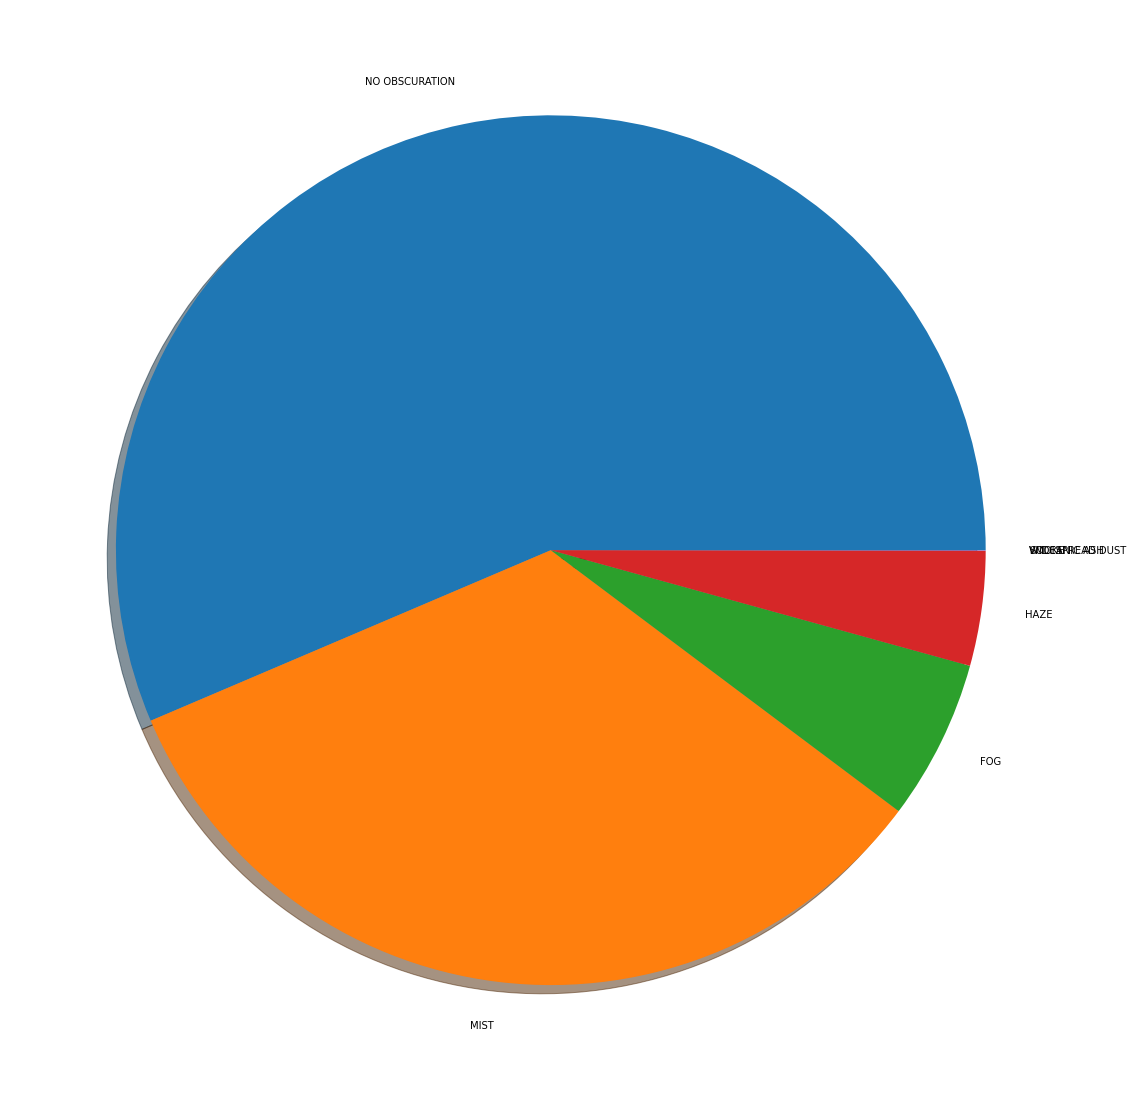

In [40]:
obsc = df['obscuration_code'].apply(lambda x: ocm[x] if x in ocm.keys() else x)
obsc_counts = obsc[obsc.notna()].value_counts()

display(obsc_counts)
plt.pie(obsc_counts, labels=obsc_counts.index.str.upper(), shadow=True)

None Reported                        289287
Squalls                                  24
Funnel Cloud, Tornado, Waterspout         4
Duststorm                                 1
Name: other_phenomena_code, dtype: int64

([<matplotlib.patches.Wedge at 0x7fe0c34d2ef0>,
 [Text(-1.0999999454399674, 0.00034645644614537393, 'NONE REPORTED'),
  Text(1.099999924984645, -0.0004062434930092695, 'SQUALLS'),
  Text(1.099999997656979, -7.17958671068697e-05, 'FUNNEL CLOUD, TORNADO, WATERSPOUT'),
  Text(1.099999999933746, -1.2073075177659153e-05, 'DUSTSTORM')])

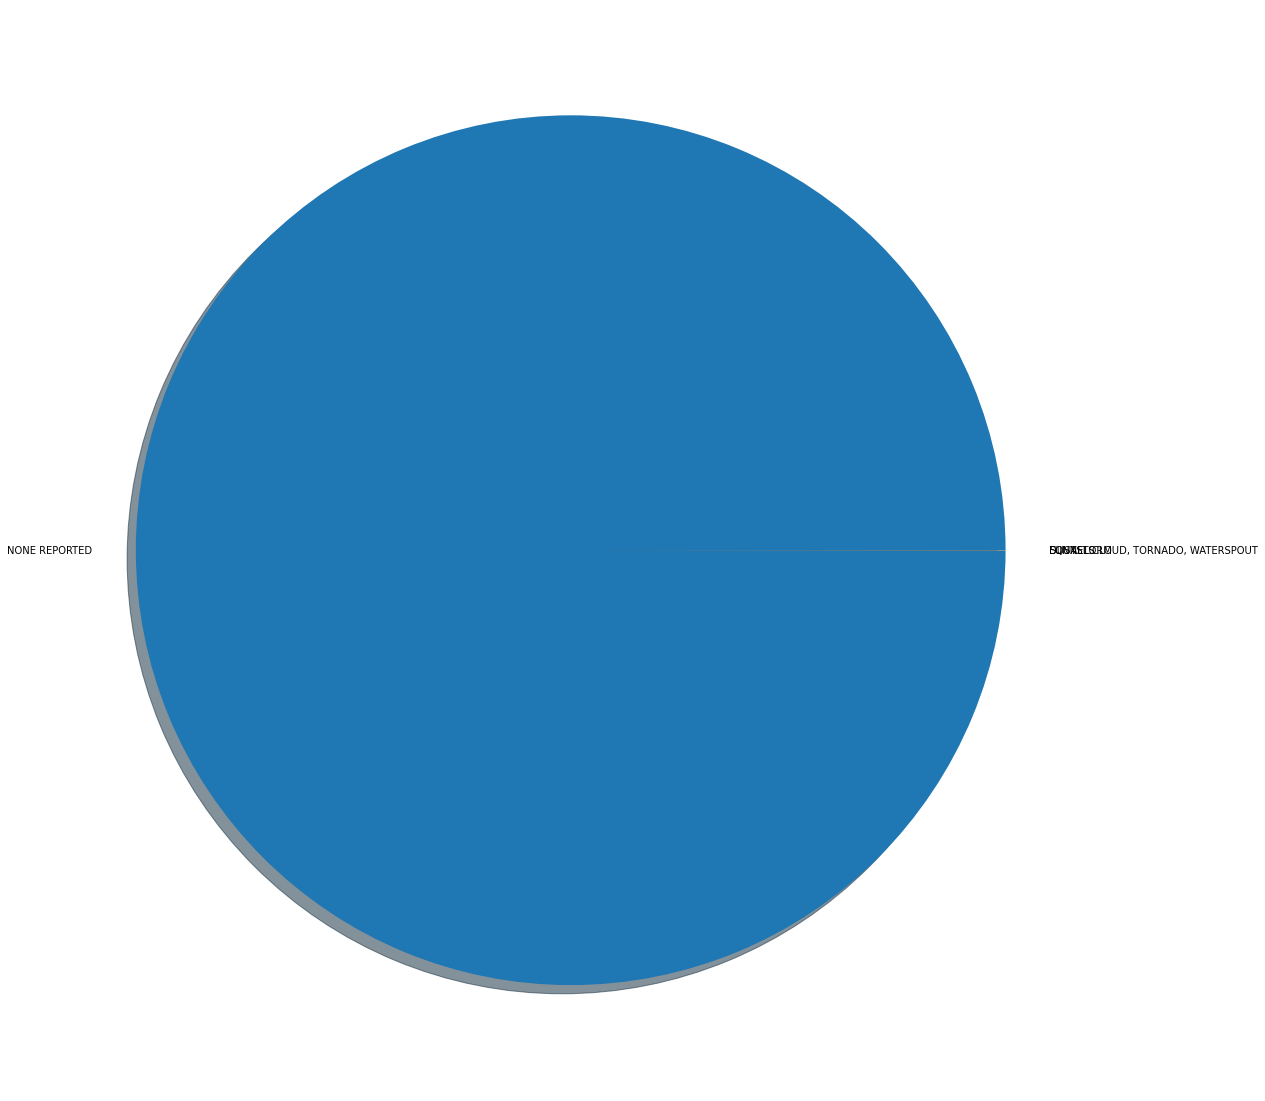

In [39]:
othphenom = df['other_phenomena_code'].apply(lambda x: opcm[x] if x in opcm.keys() else x)
opc_counts = othphenom[othphenom.notna()].value_counts()
display(opc_counts)

plt.pie(opc_counts, labels=opc_counts.index.str.upper(), shadow=True)

289316

([<matplotlib.patches.Wedge at 0x7fe08b28c070>,
 [Text(-0.18030992492902492, 1.085121343892972, 'NO PRECIPITATION'),
  Text(-0.037355322754708195, -1.0993655351437446, 'RAIN'),
  Text(1.0649086105380687, -0.2756259262150062, 'SNOW'),
  Text(1.0973373038087166, -0.07649079467371378, 'DRIZZLE'),
  Text(1.0998289694425316, -0.019396854770278922, 'UNKNOWN PRECIPITATION'),
  Text(1.0999955146090534, -0.0031413118221456154, 'ICE PELLETS'),
  Text(1.0999999790083423, -0.0002148991546167005, 'SMALL HAIL AND/OR SNOW PELLETS'),
  Text(1.0999999997428256, -2.37862153612023e-05, 'HAIL')])

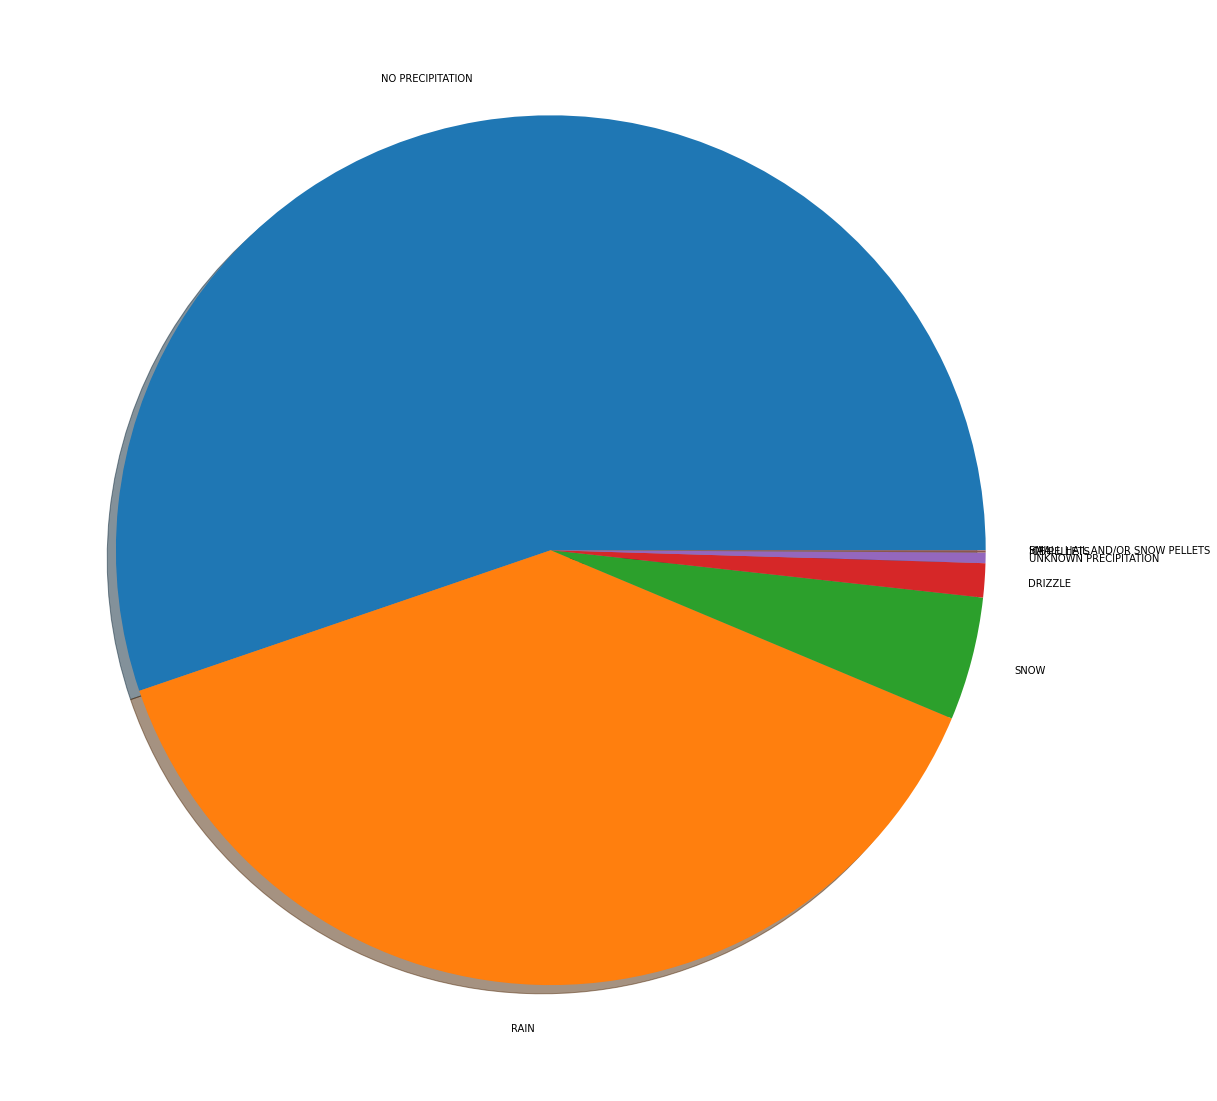

In [30]:
precip_code = df['precipitation_code'].apply(lambda x: pcm[x] if x in pcm.keys() else x)
display(len(list(precip_code[precip_code.notna()])))
pc_counts = precip_code[precip_code.notna()].value_counts()

plt.pie(pc_counts, labels=pc_counts.index.str.upper(), shadow=True)

No descriptor    249428
Thunderstorm      33667
Patches            2938
Freezing           2563
Shallow             714
Blowing               6
Name: descriptor_code, dtype: int64

([<matplotlib.patches.Wedge at 0x7fe0d6c1c5e0>,
 [Text(-0.9984214864162957, 0.46168662040639097, 'NO DESCRIPTOR'),
  Text(0.9649802220020491, -0.5280276234676327, 'THUNDERSTORM'),
  Text(1.0941474512703833, -0.11331970207569624, 'PATCHES'),
  Text(1.0989609877607818, -0.04779903116012642, 'FREEZING'),
  Text(1.0999658185700665, -0.008671676740033486, 'SHALLOW'),
  Text(1.0999999976642563, -7.16842847450902e-05, 'BLOWING')])

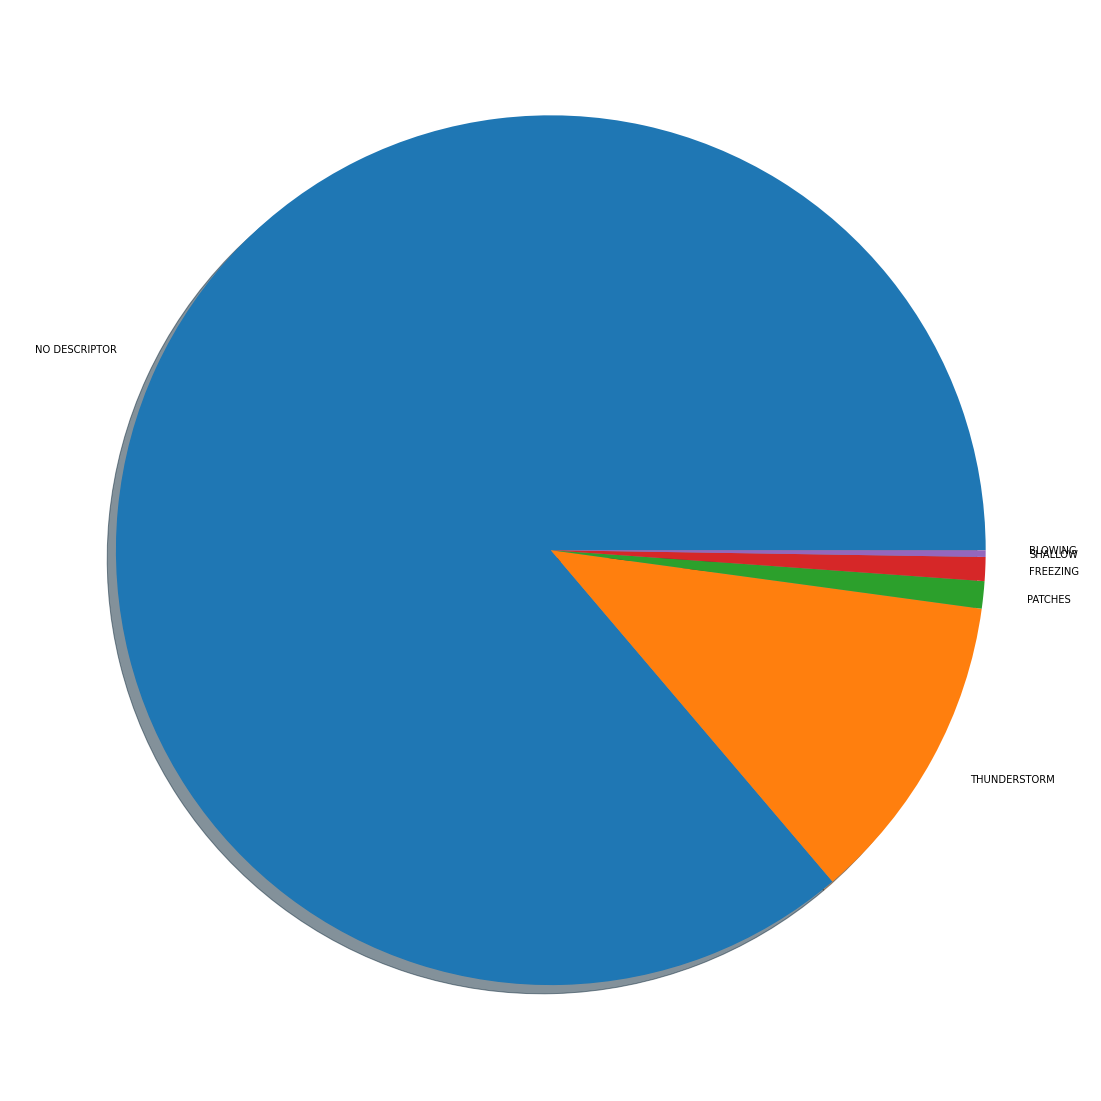

In [37]:
descriptor = df['descriptor_code'].apply(lambda x: descriptor_code_map[x] if x in descriptor_code_map.keys() else x)
dc_counts = descriptor[descriptor.notna()].value_counts()
display(dc_counts)

plt.pie(dc_counts, labels=dc_counts.index.str.upper(), shadow=True)

In [121]:
isd.isna().sum()

station                                 0
latitude                                0
longitude                               0
elevation                               0
year                                    0
month                                   0
day                                     0
hour                                    0
minute                                  0
sky_ceiling                             0
sky_ceiling_determination_code          0
visibility_variable                     0
dew_point_temperature              475550
air_temperature                    473290
wind_direction                    1122402
wind_type                               0
wind_speed                         401206
precipitation_period              1231568
precipitation_depth               1229509
precipitation_condition           3405801
proximity_intensity               3287687
descriptor_code                   3287687
precipitation_code                3287687
obscuration_code                  

In [98]:
isdlite.isna().sum()

year                              0
month                             0
day                               0
hour                              0
sea_level_pressure           362121
wind_direction               517420
wind_speed                     2235
sky_coverage                 493018
precipitation_depth          800717
station                           0
date                              0
region                            0
air_temperature                1619
dew_point_temperature        319548
saturated_vapor_pressure       1619
actual_vapor_pressure        319548
calculated_humidity          319626
short_station_id                  0
elevation                    298252
latitude                     298252
longitude                    298252
station_date                      0
station_year                      0
repl_precipitation_depth    3572751
dtype: int64

In [109]:
df = isdlite.drop(columns=['date', 'station', 'short_station_id', 'station_date', 'station_year'])

In [110]:
df['combined_precipitation_depth'] = df.apply(
    lambda x: x['repl_precipitation_depth'] if np.isnan(x['precipitation_depth']) else x['precipitation_depth'],
    axis=1
)

In [116]:
# df['precipitation_depth'] = df['combined_precipitation_depth']
# df['humidity'] = df['calculated_humidity']
# df.drop(columns=['humidity_percentage'], inplace=True)
df.drop().isna().sum()

year                             0
month                            0
day                              0
hour                             0
sea_level_pressure          362121
wind_direction              517420
wind_speed                    2235
sky_coverage                493018
precipitation_depth         739678
region                           0
air_temperature               1619
dew_point_temperature       319548
saturated_vapor_pressure      1619
actual_vapor_pressure       319548
calculated_humidity         319626
elevation                   298252
latitude                    298252
longitude                   298252
humidity                    319626
dtype: int64

In [120]:
save_feathers(df, 'week4_lite')

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3633790 entries, 0 to 3633789
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   year                      int64  
 1   month                     int64  
 2   day                       int64  
 3   hour                      int64  
 4   sea_level_pressure        float64
 5   wind_direction            float64
 6   wind_speed                float64
 7   sky_coverage              float64
 8   precipitation_depth       float64
 9   region                    object 
 10  air_temperature           float64
 11  dew_point_temperature     float64
 12  saturated_vapor_pressure  float64
 13  actual_vapor_pressure     float64
 14  calculated_humidity       float64
 15  elevation                 float64
 16  latitude                  float64
 17  longitude                 float64
 18  humidity                  float64
dtypes: float64(14), int64(4), object(1)
memory usage: 526.7+ MB


# Week 4 -- Pipeline & Initial Model

In [127]:
weather = df.dropna(subset=['precipitation_depth'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2894112 entries, 2943 to 3633789
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   year                      int64  
 1   month                     int64  
 2   day                       int64  
 3   hour                      int64  
 4   sea_level_pressure        float64
 5   wind_direction            float64
 6   wind_speed                float64
 7   sky_coverage              float64
 8   precipitation_depth       float64
 9   region                    object 
 10  air_temperature           float64
 11  dew_point_temperature     float64
 12  saturated_vapor_pressure  float64
 13  actual_vapor_pressure     float64
 14  calculated_humidity       float64
 15  elevation                 float64
 16  latitude                  float64
 17  longitude                 float64
 18  humidity                  float64
dtypes: float64(14), int64(4), object(1)
memory usage: 441.6+ MB


In [130]:
weather['precipitation'] = weather['precipitation_depth'].apply(
    lambda x: 'yes' if x > 0 else 'no'
)

weather.drop(columns=['precipitation_depth', 'calculated_humidity'], inplace=True)
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2894112 entries, 2943 to 3633789
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   year                      int64  
 1   month                     int64  
 2   day                       int64  
 3   hour                      int64  
 4   sea_level_pressure        float64
 5   wind_direction            float64
 6   wind_speed                float64
 7   sky_coverage              float64
 8   region                    object 
 9   air_temperature           float64
 10  dew_point_temperature     float64
 11  saturated_vapor_pressure  float64
 12  actual_vapor_pressure     float64
 13  calculated_humidity       float64
 14  elevation                 float64
 15  latitude                  float64
 16  longitude                 float64
 17  humidity                  float64
 18  precipitation             object 
dtypes: float64(13), int64(4), object(2)
memory usage: 441.6+ MB


## Train/Test Split

In [131]:
class_column = 'precipitation'
random_seed = 2435

X_train, X_test, y_train, y_test = train_test_split(weather.drop(columns=class_column), weather[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=weather[class_column])

In [132]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (2170584, 18)


,year,month,day,hour,sea_level_pressure,wind_direction,wind_speed,sky_coverage,region,air_temperature,dew_point_temperature,saturated_vapor_pressure,actual_vapor_pressure,calculated_humidity,elevation,latitude,longitude,humidity
2679111,2014,9,27,13,10219.0,70.0,15.0,0.0,bowling green,16.7,13.9,3.105580,2.594727,0.835505,159.3,36.96467,-86.42379,0.835505
2998968,2016,10,27,5,NaN,NaN,99.0,NaN,jackson,99.9,99.9,169.735883,169.735883,1.000000,129.2,35.59332,-88.91696,1.000000
2447383,1954,9,23,9,10198.0,45.0,21.0,0.0,knoxville,12.2,8.9,2.322031,1.863802,0.802660,295.8,35.81801,-83.98573,0.802660
3272324,2012,11,13,7,NaN,NaN,1.0,NaN,knoxville,-1.9,NaN,0.870340,NaN,NaN,NaN,NaN,NaN,NaN
2610965,2001,9,5,21,10167.0,40.0,26.0,4.0,chattanooga,31.7,21.1,7.641581,4.087437,0.534894,204.0,35.03363,-85.20039,0.534894



On X test: 
X test dimensions:  (723528, 18)


,year,month,day,hour,sea_level_pressure,wind_direction,wind_speed,sky_coverage,region,air_temperature,dew_point_temperature,saturated_vapor_pressure,actual_vapor_pressure,calculated_humidity,elevation,latitude,longitude,humidity
2902994,1999,10,24,22,10225.0,0.0,0.0,0.0,knoxville,11.1,0.0,2.159339,1.000000,0.463105,295.8,35.81801,-83.98573,0.463105
2066226,2013,7,8,21,10192.0,70.0,26.0,6.0,nashville,30.0,21.7,6.934642,4.240462,0.611490,178.9,36.11054,-86.68815,0.611490
1982456,1996,7,13,18,10146.0,999.0,26.0,0.0,chattanooga,28.3,21.1,6.285454,4.087437,0.650301,204.0,35.03363,-85.20039,0.650301
3090702,1971,11,28,4,NaN,20.0,36.0,8.0,chattanooga,5.6,0.6,1.487296,1.044360,0.702187,204.0,35.03363,-85.20039,0.702187
2298498,1999,8,8,7,10131.0,0.0,0.0,0.0,knoxville,22.2,17.8,4.371794,3.329256,0.761531,295.8,35.81801,-83.98573,0.761531


In [133]:
# X Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# X test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (2170584,)


2679111    no
2998968    no
2447383    no
3272324    no
2610965    no
Name: precipitation, dtype: object


On y test: 
y test dimensions:  (723528,)


2902994    no
2066226    no
1982456    no
3090702    no
2298498    no
Name: precipitation, dtype: object

## Training Pipelines

In [134]:
#individual pipelines for differing datatypes
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
                               ('scale_num', StandardScaler())])

In [135]:
#establish preprocessing pipeline by columns
preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

In [136]:
#generate the whole modeling pipeline with preprocessing
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

#visualization for steps
with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdfd3b616c0>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdfd3b61f60>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

## Cross-validation and Hyperparameter Tuning

In [137]:
tuning_grid = {'mdl__l1_ratio' : np.linspace(0,1,5),
               'mdl__C': np.logspace(-1, 6, 3) }
grid_search = GridSearchCV(pipe, param_grid = tuning_grid, cv = 5, return_train_score=True)

In [138]:
tuning_grid

{'mdl__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 'mdl__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06])}

In [139]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fdfd3b616c0>),
                                                                        ('num_pipe',
                                                    

In [140]:
print(grid_search.best_score_)
grid_search.best_params_

0.9217726657679798


{'mdl__C': 0.1, 'mdl__l1_ratio': 0.25}

In [141]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mdl__C,param_mdl__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,19.848681,0.786488,1.113018,0.056870,0.1,0.0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}",0.922039,0.921560,0.921710,...,0.921770,0.000158,2,0.921677,0.921838,0.921765,0.921763,0.921791,0.921767,0.000053
1,21.058619,0.619395,1.111845,0.035083,0.1,0.25,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.25}",0.922039,0.921560,0.921710,...,0.921773,0.000158,1,0.921676,0.921842,0.921767,0.921768,0.921792,0.921769,0.000054
2,21.234425,0.564315,1.088052,0.014001,0.1,0.5,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.5}",0.922037,0.921558,0.921710,...,0.921762,0.000156,5,0.921679,0.921842,0.921766,0.921738,0.921792,0.921763,0.000054
3,21.000729,0.493615,1.079211,0.024221,0.1,0.75,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.75}",0.922037,0.921560,0.921708,...,0.921761,0.000156,6,0.921678,0.921841,0.921763,0.921739,0.921790,0.921762,0.000054
4,21.248402,0.619909,1.120023,0.016721,0.1,1.0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 1.0}",0.922039,0.921558,0.921710,...,0.921763,0.000157,3,0.921683,0.921837,0.921768,0.921739,0.921795,0.921764,0.000052
5,19.717576,0.438892,1.106339,0.016041,316.227766,0.0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.922039,0.921556,0.921710,...,0.921760,0.000158,10,0.921675,0.921841,0.921761,0.921736,0.921792,0.921761,0.000056
6,21.178436,0.572373,1.095792,0.010446,316.227766,0.25,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.922042,0.921549,0.921712,...,0.921760,0.000160,7,0.921675,0.921842,0.921761,0.921744,0.921795,0.921763,0.000055
7,21.526026,0.756533,1.106907,0.022778,316.227766,0.5,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.922042,0.921533,0.921710,...,0.921757,0.000165,12,0.921674,0.921823,0.921764,0.921736,0.921793,0.921758,0.000051
8,21.435909,0.517206,1.127143,0.023577,316.227766,0.75,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.922046,0.921544,0.921710,...,0.921760,0.000164,11,0.921674,0.921841,0.921760,0.921739,0.921790,0.921761,0.000055
9,21.220739,0.441552,1.096211,0.011770,316.227766,1.0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.922044,0.921546,0.921710,...,0.921760,0.000162,7,0.921675,0.921839,0.921761,0.921738,0.921789,0.921760,0.000054


## Final Fit

In [142]:
grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdfd3b60e80>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

## Variable Importance

In [143]:
grid_search.classes_

array(['no', 'yes'], dtype=object)

In [144]:
vip = grid_search.best_estimator_['mdl'].coef_[0]
vip

array([ 1.42275370e-01, -8.27564092e-01, -5.12286579e-02, -3.80088225e-01,
       -7.98236096e-01, -8.47029416e-01,  8.97103150e-02, -8.14192201e-03,
        1.02501067e-03,  6.61752266e-02, -4.84673255e-01, -1.02403985e-01,
        8.92203195e-02,  1.08648258e+00, -1.18989783e+00,  1.16329927e+00,
        3.78579548e-01, -4.26941752e-01,  1.11711537e-02, -2.57644709e-01,
       -1.04543072e-01,  8.40764803e-02,  1.11711537e-02])

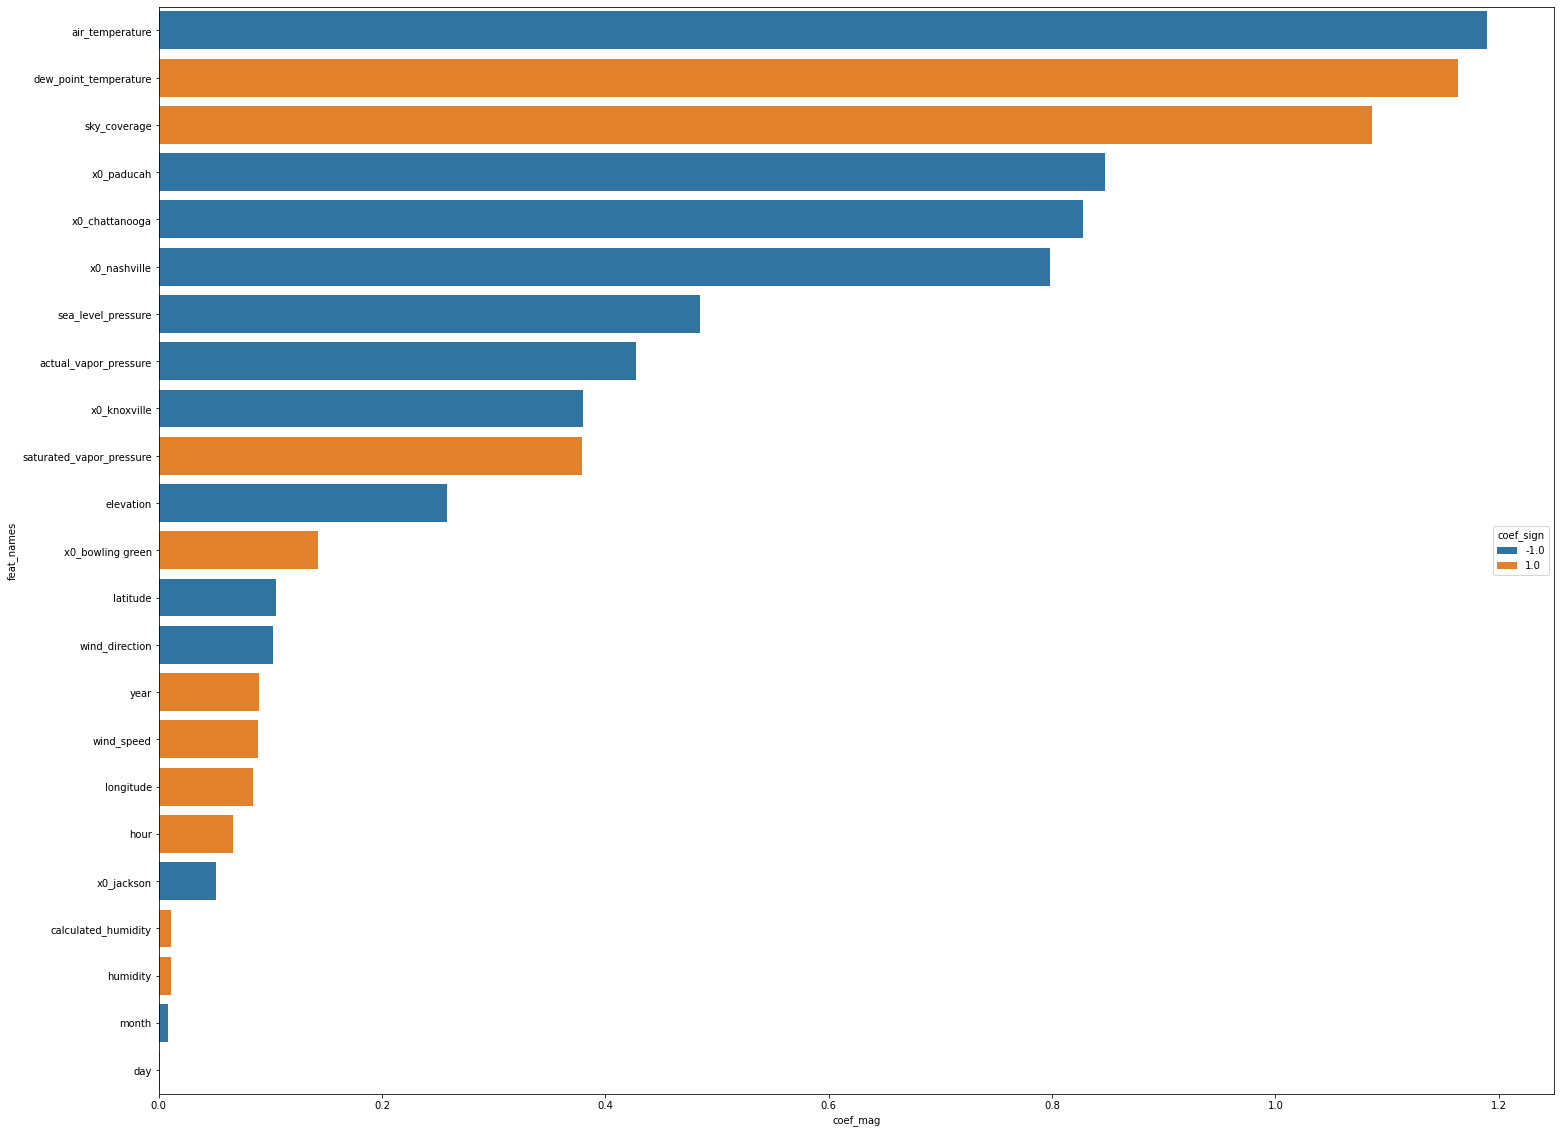

In [146]:
#get names in correct preproc order
cat_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names_out()
num_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

#create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip})

#get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

#sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False);

## Performance metrics on test data

In [147]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

          no       0.93      1.00      0.96    667567
         yes       0.44      0.04      0.07     55961

    accuracy                           0.92    723528
   macro avg       0.68      0.52      0.52    723528
weighted avg       0.89      0.92      0.89    723528



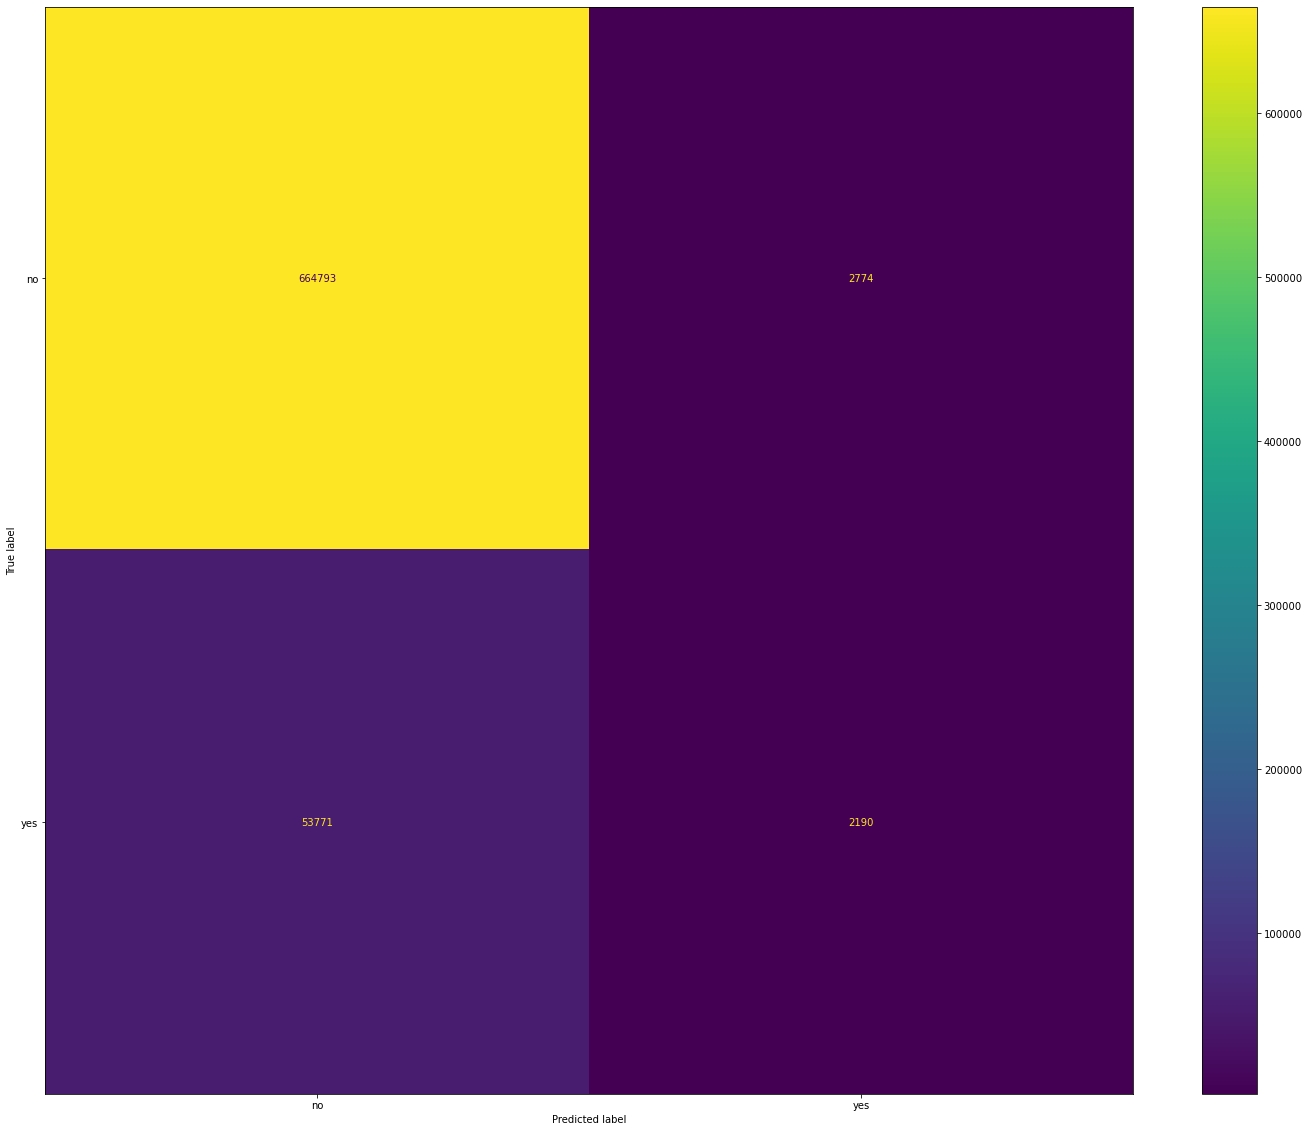

In [148]:
cm = confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid_search.classes_)
disp.plot()

plt.show()

Best Threshold=0.088218, Net Gain=0.518


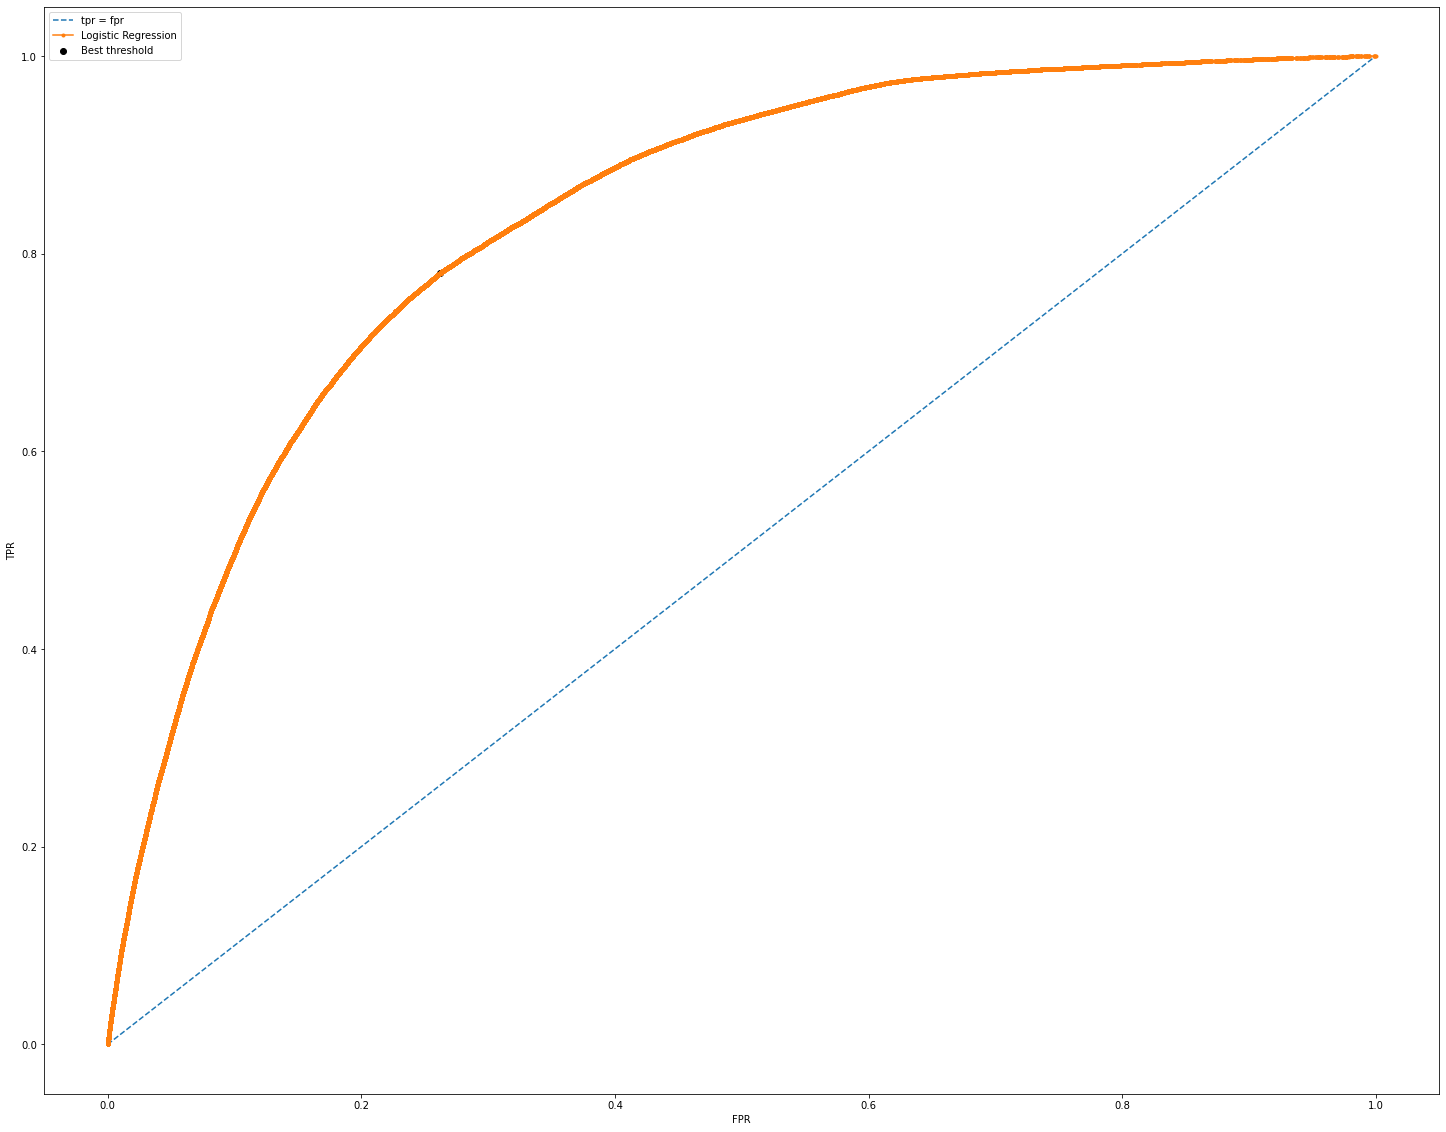

In [153]:
y_pred = grid_search.best_estimator_.predict_proba(X_test)
y_pred = y_pred[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label='yes')

net_gain = tpr - fpr

# find the index of highest net_gain
ix = np.argmax(net_gain)
print('Best Threshold=%f, Net Gain=%.3f' % (thresholds[ix], net_gain[ix]))

# plot roc curve
plt.plot([0,1], [0,1], linestyle='--', label='tpr = fpr')
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best threshold')

# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()